# Analisi dell’Impatto del Dithering sulla Classificabilità delle Immagini con Reti Neurali Convoluzionali (CNN)

In questo progetto analizzeremo come la **quantizzazione** e diverse tecniche di **dithering** influenzino la capacità di una **rete neurale convoluzionale (CNN)** di classificare correttamente immagini realistiche.

Utilizzeremo un sottoinsieme del dataset **Caltech 256**, composto da **5 classi di oggetti**, ciascuna con 100 immagini.

La riduzione della profondità di colore (es. da 8 bit a 2 bit per canale) degrada la qualità visiva delle immagini, rendendo più difficile il compito di classificazione.  
Per mitigare questo effetto, si possono applicare tecniche di **dithering**, che simulano le sfumature perse distribuendo l’errore visivo nei pixel vicini.

## Approccio utilizzato
Addestreremo una **rete neurale convoluzionale (CNN)** su immagini originali e la testeremo per stabilire un benchmark. Successivamente, testeremo il modello anche su versioni **quantizzate** e **ditherizzate** delle immagini.

Infine, valuteremo se il dithering migliora non solo la percezione visiva umana, ma anche la **classificazione automatica** da parte del modello.

## Struttura del notebook
- Caricamento e preprocessing del dataset
- Definizione della CNN e training sulle immagini originali
- Applicazione delle tecniche di degradazione (quantizzazione e dithering)
- Valutazione delle performance su immagini originali e degradate
- Analisi e confronto dei risultati


# 1. Inizializzazione del progetto

In questa fase importiamo le librerie principali che useremo per il caricamento, la manipolazione delle immagini e la costruzione della rete neurale convoluzionale (CNN).

Definiamo inoltre il dataset e la dimensione alla quale ridimensionare tutte le immagini (es. 128x128 pixel), in modo da poterle elaborare in modo uniforme.


In [1]:
# 1. Import delle librerie principali

import os                                               # Per gestire i file e le cartelle
import numpy as np                                      # Per operazioni numeriche e matriciali
import matplotlib.pyplot as plt                         # Per visualizzare le immagini
from sklearn.model_selection import train_test_split    # Per dividere il dataset in training e test
from sklearn.metrics import accuracy_score              # Per calcolare l'accuratezza del modello
from sklearn.metrics import confusion_matrix            # Per calcolare la matrice di confusione
import seaborn as sns                                   # Per visualizzare la matrice di confusione


from tensorflow.keras.preprocessing.image import load_img, img_to_array             # Per caricare e preprocessare le immagini
from tensorflow.keras.models import Sequential                                      # Per costruire il modello di rete neurale
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout   # Per aggiungere i layer alla rete neurale
from tensorflow.keras.optimizers import Adam                                        # Per ottimizzare il modello
from tensorflow.keras.callbacks import EarlyStopping                                # Per fermare l'addestramento in anticipo se non ci sono miglioramenti

# Percorso della cartella contenente le 5 sottocartelle (classi)
dataset_path = "Dataset"

# Dimensione target per il resize delle immagini
img_size = (128, 128)


import random               # Per generare numeri casuali
import tensorflow as tf     # Per costruire e addestrare il modello di rete neurale

# Impostazione del seed per la riproducibilità dei risultati
seed = 2
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


# 2. Caricamento e Preprocessing delle Immagini

In questa fase carichiamo tutte le immagini contenute nelle 5 sottocartelle del dataset.  
Per ciascuna immagine vengono eseguite le seguenti operazioni:
- Ridimensionamento a 128x128 pixel
- Conversione in array NumPy
- Assegnazione dell’etichetta numerica in base alla sottocartella di appartenenza

Al termine, otterremo due array: uno con i dati delle immagini (X) e uno con le relative etichette (y).


In [2]:
# 2. Caricamento delle immagini

X = [] # lista per le immagini
y = [] # lista per le etichette

class_names = sorted(os.listdir(dataset_path))                      # nomi delle classi in ordine alfabetico, vengono prese dai nomi delle sottocartelle
label_map = {name: idx for idx, name in enumerate(class_names)}     # mappa dei nomi delle classi agli indici ("butterfly": 0, "dolphin": 1, "laptop": 2, ecc.)

# Scorriamo le sottocartelle e carichiamo le immagini
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    label = label_map[class_name]


    for img_name in os.listdir(class_path):             # Scorriamo le immagini nella sottocartella
        
        img_path = os.path.join(class_path, img_name)   # Costruiamo il percorso completo dell'immagine
        
        img = load_img(img_path, target_size=img_size)  # Carichiamo l'immagine e la ridimensioniamo alla dimensione target (128x128)
        
        img_array = img_to_array(img) / 255.0           # Converto l'immagine in un array NumPy e normalizzato i pixel tra 0 e 1
        
        
        X.append(img_array) # Aggiungo l'immagine all'elenco X
        y.append(label)     # Aggiungo l'etichetta corrispondente all'elenco y


# Convertiamo in array NumPy le liste X e y
X = np.array(X)
y = np.array(y)


print("Immagini caricate:", X.shape)
print("Etichette caricate:", y.shape)


Immagini caricate: (500, 128, 128, 3)
Etichette caricate: (500,)


## 2.1 Visualizzazione di alcune immagini

Prima di procedere con la suddivisione in training e test set, visualizziamo alcune immagini campione prelevate dal dataset appena caricato.  
Ogni immagine è stata ridimensionata a 128x128 pixel.


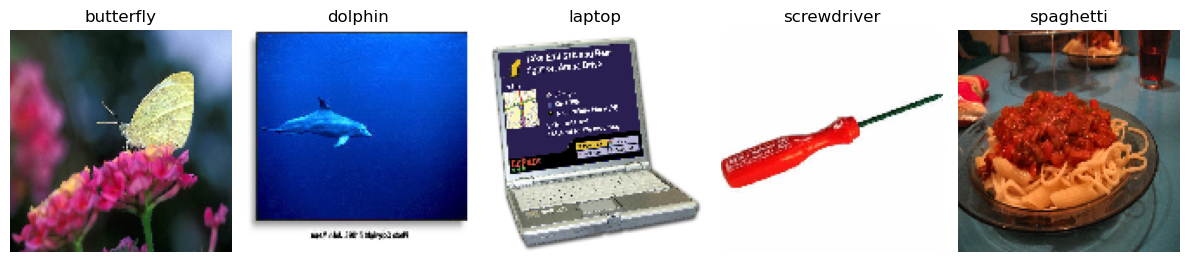

In [3]:
# Visualizza una immagine per ciascuna delle 5 classi

plt.figure(figsize=(12, 6))
shown = set()

# Scorriamo tutte le immagini
for i in range(len(X)): 
    label = y[i]
    class_name = class_names[label]
    
    # Ma mostriamo solo una immagine per classe
    if class_name not in shown:
        plt.subplot(1, len(class_names), len(shown) + 1)
        plt.imshow(X[i])
        plt.title(class_name)
        plt.axis('off')
        shown.add(class_name)
    
    if len(shown) == len(class_names): # Abbiamo mostrato tutte le classi
        break


plt.tight_layout()
plt.show()

# 3. Suddivisione del Dataset

Dividiamo ora il dataset in due insiemi:
- Un **training set** (90%) su cui addestrare la rete neurale
- Un **test set** (10%) per valutarne le performance

La suddivisione avviene in modo stratificato, per garantire che ogni classe sia rappresentata proporzionalmente in entrambi gli insiemi.


In [4]:
# 3. Suddivisione in train e test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=seed
)


print("Train set:", X_train.shape, y_train.shape)
print("Test set :", X_test.shape, y_test.shape)


Train set: (450, 128, 128, 3) (450,)
Test set : (50, 128, 128, 3) (50,)


# 4. Costruzione e Addestramento della Rete Neurale Convoluzionale (CNN)

In questa fase costruiamo una rete neurale convoluzionale (CNN).

La rete verrà addestrata **solo sulle immagini originali** (non degradate), e ci servirà come punto di riferimento per confrontare in seguito le performance su immagini quantizzate e con dithering.

L'architettura adottata è la seguente:

- **3 strati convoluzionali** con funzione di attivazione ReLU, ciascuno seguito da un **max pooling**
- 1 strato **fully-connected** (denso) con attivazione ReLU
- Un livello di **dropout** per ridurre l'overfitting
- Uno **strato di output** con attivazione softmax per classificare le immagini nelle diverse categorie

In [5]:
# 4. Costruzione del modello CNN

input_shape = (128, 128, 3)  # Dimensione delle immagini in input: 128x128 pixel con 3 canali (RGB)


model = Sequential([                                                # Creazione del modello sequenziale 
    
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), # Primo layer convoluzionale con 32 filtri, kernel 3x3 e funzione di attivazione ReLU
    MaxPooling2D(pool_size=(2, 2)),                                 # Layer di pooling per ridurre la dimensione spaziale


    Conv2D(64, (3, 3), activation='relu'),  # Secondo layer convoluzionale con 64 filtri, kernel 3x3 e funzione di attivazione ReLU
    MaxPooling2D(pool_size=(2, 2)),         # Layer di pooling per ridurre la dimensione spaziale


    Conv2D(128, (3, 3), activation='relu'), # Terzo layer convoluzionale con 128 filtri, kernel 3x3 e funzione di attivazione ReLU
    MaxPooling2D(pool_size=(2, 2)),         # Layer di pooling per ridurre la dimensione spaziale


    Flatten(),                                      # Appiattimento della matrice 3D in un vettore 1D per l'input al layer denso
    
    Dense(128, activation='relu'),                  # Layer denso con 128 neuroni e funzione di attivazione ReLU
    
    Dropout(0.5),                                   # Dropout per prevenire l'overfitting, disattivando il 70% dei neuroni in modo casuale durante l'addestramento
    
    Dense(len(np.unique(y)), activation='softmax')  # Layer di output con un neurone per classe. Restituisce una probabilità per ciascuna classe usando la funzione di attivazione softmax
])


model.compile(
    optimizer=Adam(learning_rate=0.001),    # Ottimizzatore Adam con un learning rate di 0.001
    loss='sparse_categorical_crossentropy', # Funzione di loss per la classificazione multiclasse
    metrics=['accuracy']                    # Metriche da monitorare durante l'addestramento e la valutazione del modello
)


model.summary() # Mostra un riepilogo della struttura del modello

c:\Users\loren\miniconda3\envs\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## 4.1 Addestramento del Modello

Addestriamo ora la rete neurale convoluzionale (CNN) utilizzando il training set composto da immagini originali.

L’addestramento verrà monitorato su un piccolo validation set (ricavato automaticamente dal training set), e useremo la metrica dell'**accuracy** per valutare le prestazioni del modello.

Per ridurre il rischio di overfitting, applichiamo anche una strategia di **early stopping**, che interrompe l’addestramento quando la performance sulla validazione smette di migliorare.

In [6]:
# 4.1 Addestramento del modello

early_stop = EarlyStopping(patience=5, restore_best_weights=True) # Ferma l'addestramento se non ci sono miglioramenti per 5 epoche


# history contiene le informazioni sull'addestramento del modello, come la loss e l'accuratezza per ogni epoca
history = model.fit(
    X_train, y_train,
    validation_split=0.1,  # 10% del training set per validazione
    epochs=50,
    batch_size=8,
    callbacks=[early_stop]
)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.3235 - loss: 1.4543 - val_accuracy: 0.4667 - val_loss: 1.4603
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.4667 - loss: 1.2543 - val_accuracy: 0.6667 - val_loss: 1.3984
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5531 - loss: 1.1644 - val_accuracy: 0.6667 - val_loss: 1.2887
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5802 - loss: 1.1118 - val_accuracy: 0.6889 - val_loss: 1.2886
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.6346 - loss: 0.9736 - val_accuracy: 0.7333 - val_loss: 1.1465
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.6938 - loss: 0.8527 - val_accuracy: 0.6000 - val_loss: 1.2416
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.7284 - loss: 0.6982 - val_accuracy: 0.6444 - val_loss: 1.2182
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.7728 - loss: 0.6039 - val_accuracy: 0.6222 - v

# 5. Valutazione del Modello sul Test Set Originale

Dopo aver completato l'addestramento della rete neurale, procediamo con la valutazione del modello sul **test set originale**, che contiene immagini non degradate.

Questa valutazione ci fornirà un **benchmark di riferimento**: l'accuratezza ottenuta su immagini "pulite" ci servirà per confrontare successivamente le prestazioni del modello su immagini **quantizzate** e **ditherizzate**.

Misureremo la performance tramite la **accuracy**, ovvero la percentuale di immagini correttamente classificate nel test set.


In [7]:
# 5. Valutazione del modello sul test set originale

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)    # Facciamo la valutazione del modello sul test set

print(f"\nAccuracy sul test set originale: {test_accuracy:.4f}")        # Stampa l'accuratezza del modello sul test set originale


2/2 - 0s - 65ms/step - accuracy: 0.7000 - loss: 0.8498

Accuracy sul test set originale: 0.7000


# 6. Quantizzazione e Dithering delle Immagini del Test Set

In questa fase applichiamo diverse trasformazioni alle immagini del **test set**.

Lavorando ora su **immagini a colori**, le trasformazioni di quantizzazione e dithering saranno applicate **separatamente su ciascun canale** (R, G, B).

Le tecniche che considereremo sono:

1. **Quantizzazione uniforme** a 2 bit per canale: riduzione diretta dei livelli per ciascun canale.
2. **Random Dithering**: aggiunta di rumore casuale ai canali prima della quantizzazione.
3. **Ordered Dithering**: utilizzo di una matrice di Bayer replicata per ogni canale per introdurre un pattern regolare.
4. **Error Diffusion (Floyd–Steinberg)**: propagazione dell’errore di quantizzazione ai pixel vicini separatamente su R, G e B.

Per ogni immagine, mostreremo i risultati visivi delle trasformazioni per comprendere come ciascuna tecnica influisca sull’aspetto dell’immagine.

Infine, testeremo le performance del nostro classificatore anche su queste immagini degradate, per valutare l’impatto effettivo sulla classificazione.



In [8]:
# Funzione di quantizzazione uniforme
def quantize(img, n_bits=2):
    levels = 2 ** n_bits                                            # Calcola il numero di livelli
    img_norm = img / 255.0                                          # Normalizza in [0, 1]
    
    quantized = np.floor(img_norm * (levels - 1)) / (levels - 1)    # Quantizza l'immagine
                                                                    # mappa i valori da [0, 1] a [0, levels-1]
                                                                    # tronco i valori a livelli discreti
                                                                    # e divide per (levels - 1) per riportare in [0, 1]
                                                                    
    return (quantized * 255).astype(np.uint8)                       # Riporta in [0, 255] 



# Dithering randomico
def dither_random(img, n_bits=2):
    levels = 2 ** n_bits                                                # Calcola il numero di livelli
    img_norm = img / 255.0                                              # Normalizza in [0, 1]
    
    noise = np.random.uniform(-0.5/levels, 0.5/levels, img.shape)       # Creazione rumore casuale.
                                                                        # noise è un array della stessa dimensione dell'immagine con valori casuali tra -0.5/levels e 0.5/levels
    noisy = img_norm + noise                                            # Somma il rumore
    
    noisy = np.clip(noisy, 0, 1)                                        # Limita i valori in [0, 1] 
    
    quantized = np.floor(noisy * (levels - 1)) / (levels - 1)           # Quantizza l'immagine (come sopra)
    return (quantized * 255).astype(np.uint8)                           # Riporta in [0, 255]



# Costruzione matrice di Bayer (Ordered Dithering)
def bayer_matrix(n):
    if n == 2:
        return np.array([[0, 2],
                         [3, 1]])
        
    smaller = bayer_matrix(n//2) # Ricorsione per costruire la matrice di Bayer più piccola
    
    # restituisce la matrice di Bayer di dimensione n x n
    return np.block([[4*smaller, 4*smaller + 2],
                     [4*smaller + 3, 4*smaller + 1]])


def dither_ordered(img, n_bits=2, matrix_size=4):
    levels = 2 ** n_bits                                                                    # Calcola il numero di livelli
    img_norm = img / 255.0                                                                  # Normalizza in [0, 1]
    
    M = bayer_matrix(matrix_size)                                                           # Costruisce la matrice di Bayer
    M = (M + 0.5) / (matrix_size ** 2)                                                      # e la normalizza
    
    threshold = np.tile(M, (img.shape[0] // matrix_size + 1, img.shape[1] // matrix_size + 1))  # Replica la matrice su tutta l'immagine
    threshold = threshold[:img.shape[0], :img.shape[1]]                                         # La ritaglia alla dimensione dell'immagine
    
    
    # Applica su ciascun canale separatamente
    result = np.zeros_like(img_norm)
    for c in range(3):  # per ogni canale (R, G, B)
        noisy = img_norm[..., c] + (threshold - 0.5) / levels           # Aggiunge il rumore, threshold è una matrice della stessa dimensione dell'immagine ed ha valori tra 0 e 1
        noisy = np.clip(noisy, 0, 1)                                    # Limita i valori in [0, 1]
        result[..., c] = np.floor(noisy * (levels - 1)) / (levels - 1)  # Quantizza l'immagine (come sopra)
    
    return (result * 255).astype(np.uint8)                              # Riporta in [0, 255]



# Error Diffusion (Floyd–Steinberg)
def dither_floyd_steinberg(img, n_bits=2):
    levels = 2 ** n_bits                                                        # Calcola il numero di livelli
    img_norm = img / 255.0                                                      # Normalizza in [0, 1]
    
    out = img_norm.copy()                                                       # Crea una copia dell'immagine

    for y in range(img.shape[0]):                                               # Scorre le colonne
        for x in range(img.shape[1]):                                           # Scorre le righe
            for c in range(3):                                                  # Scorre i canali (R, G, B)
                
                old_pixel = out[y, x, c]                                        # Prende il pixel corrente
                new_pixel = np.round(old_pixel * (levels - 1)) / (levels - 1)   # Quantizza il pixel
                out[y, x, c] = new_pixel                                        # Aggiorna il pixel
                error = old_pixel - new_pixel                                   # Calcola l'errore di quantizzazione che deve essere distribuito


                # Distribuzione dell'errore secondo lo schema di Floyd-Steinberg
                if x + 1 < img.shape[1]:
                    out[y, x + 1, c] += error * 7 / 16          # pixel a destra
                if y + 1 < img.shape[0]: 
                    if x > 0:
                        out[y + 1, x - 1, c] += error * 3 / 16  # pixel in basso a sinistra
                    out[y + 1, x, c]     += error * 5 / 16      # pixel in basso
                    if x + 1 < img.shape[1]:
                        out[y + 1, x + 1, c] += error * 1 / 16  # pixel in basso a destra
    
    # Fine distribuzione dell'errore
    
    out = np.clip(out, 0, 1)            # Limita i valori in [0, 1]
    return (out * 255).astype(np.uint8) # Riporta in [0, 255]


## 6.1 Visualizzazione Comparativa delle Trasformazioni

Per comprendere meglio l'effetto visivo della **quantizzazione** e delle varie tecniche di **dithering**, applichiamo tutte le trasformazioni a un piccolo campione di immagini del test set.

Per ciascuna immagine mostreremo:

- L'immagine originale a 8 bit per canale
- La versione quantizzata a 2 bit per canale (senza dithering)
- La versione con **dithering randomico**
- La versione con **ordered dithering** (matrice di Bayer)
- La versione con **error diffusion** (algoritmo di Floyd–Steinberg)

Questo confronto visivo ci aiuterà a osservare come le tecniche di dithering cerchino di preservare i dettagli nonostante la riduzione della profondità di colore.


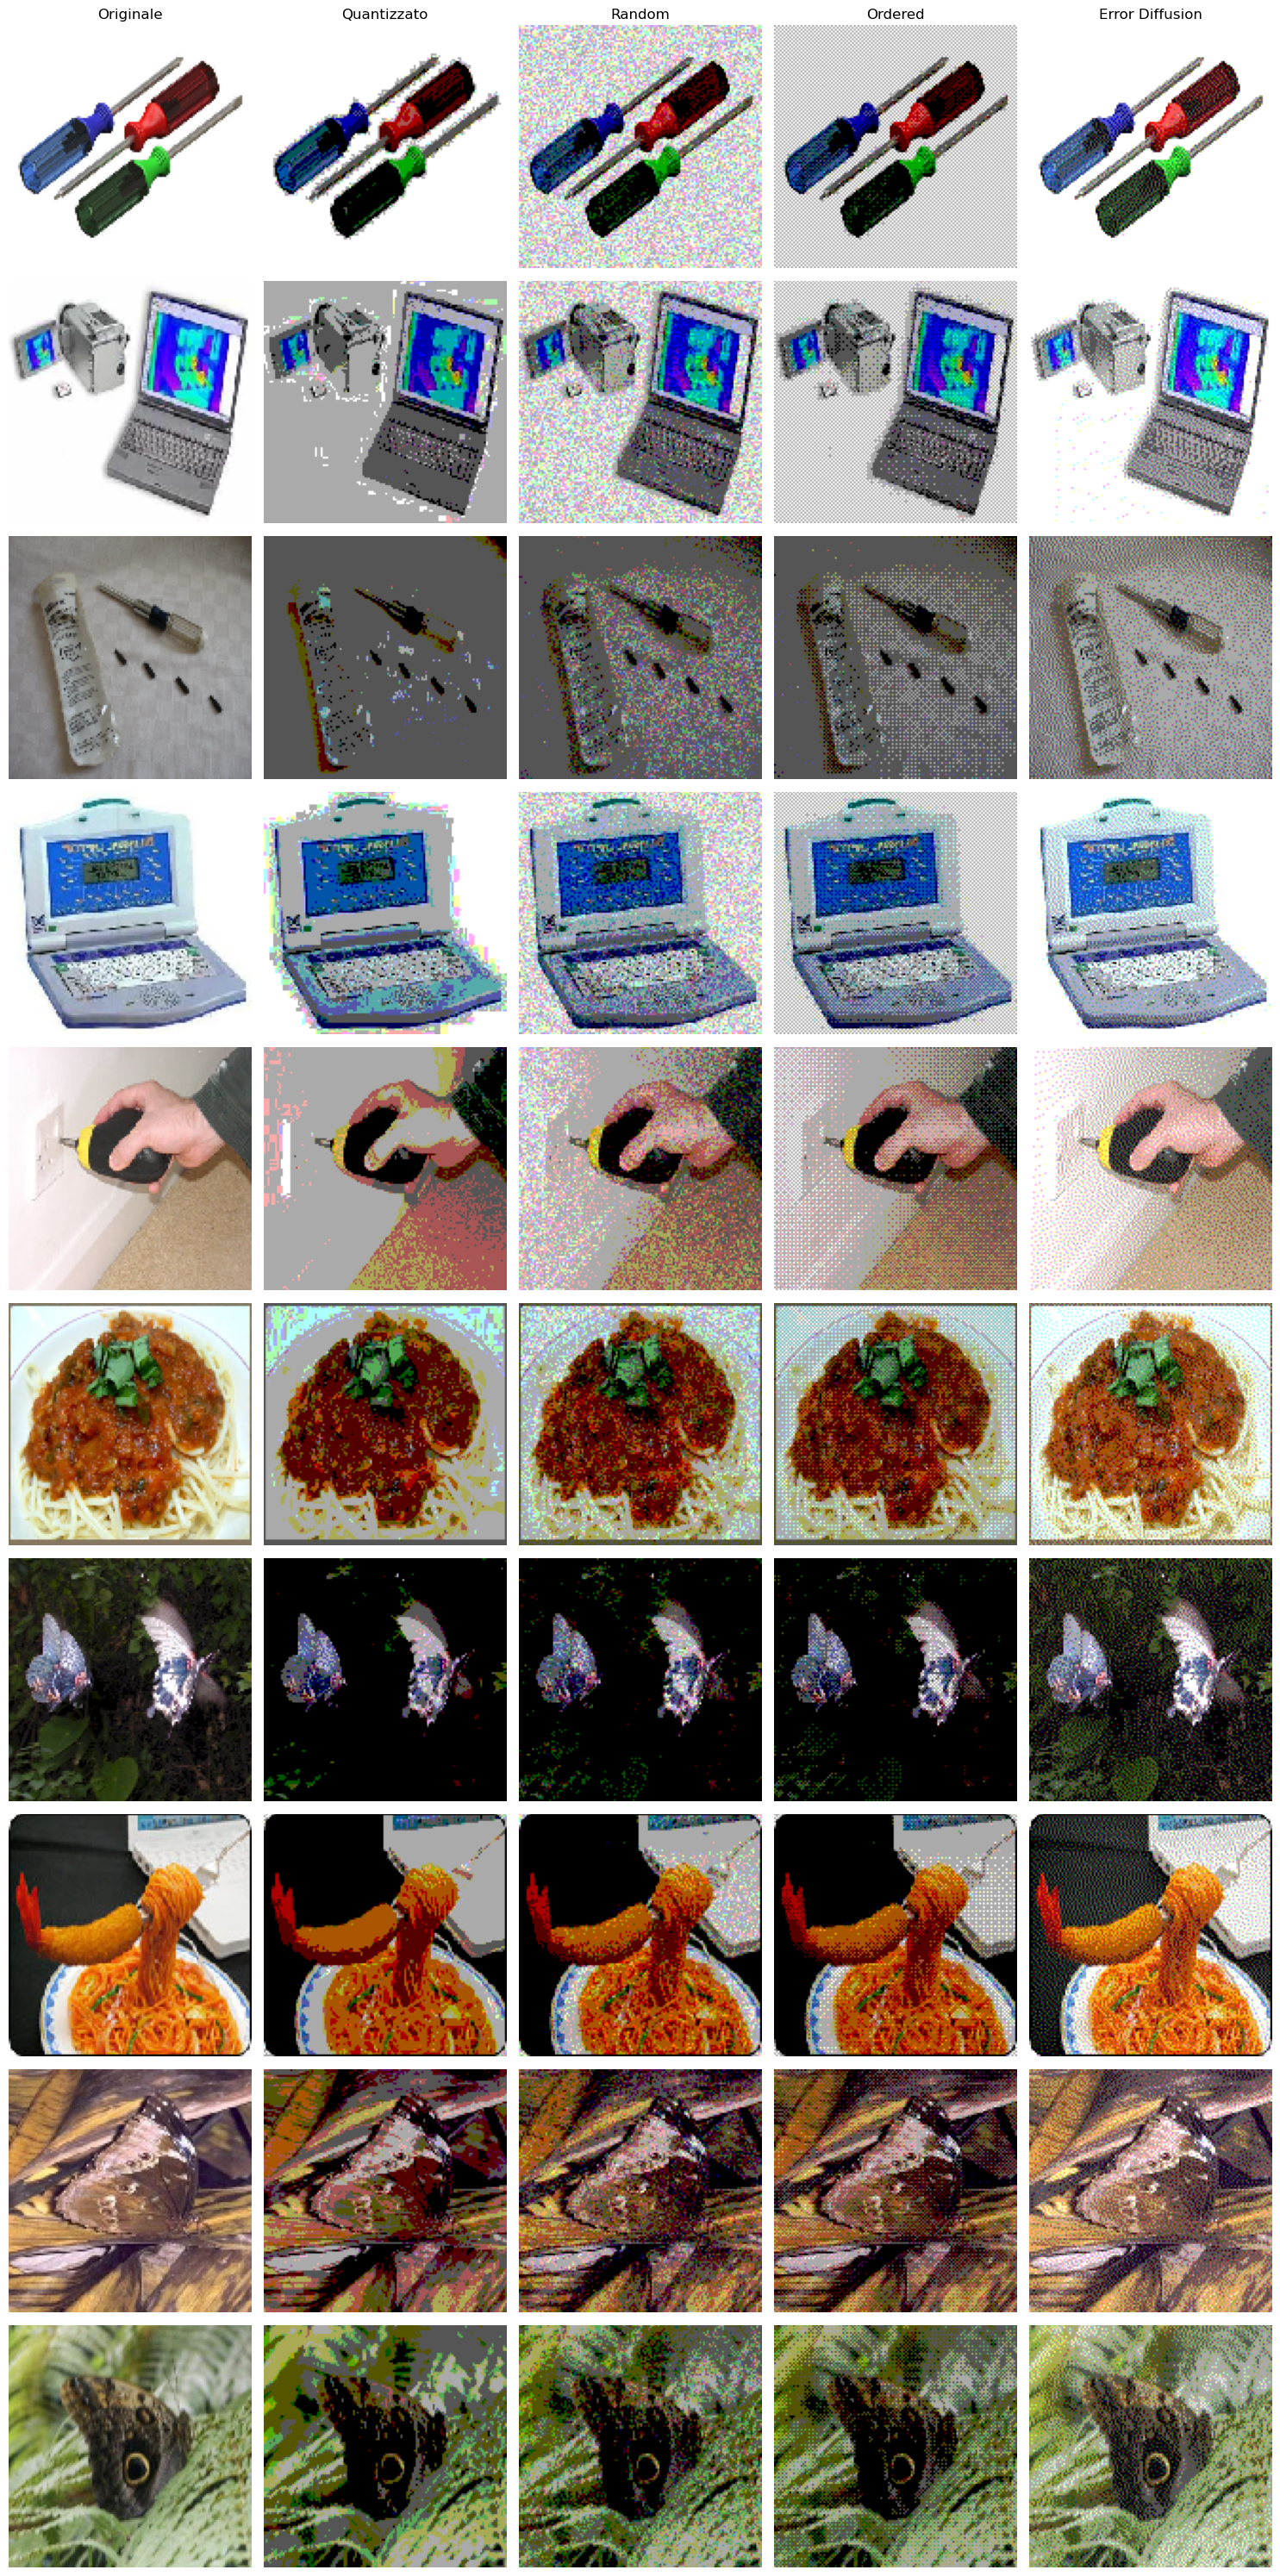

In [9]:
# Numero di immagini da mostrare
num_images = 10
indices = np.random.choice(len(X_test), num_images, replace=False) # Seleziona casualmente "num_images" indici

# Visualizzazione
titles = ["Originale", "Quantizzato", "Random", "Ordered", "Error Diffusion"]

plt.figure(figsize=(15, 3 * num_images)) # Impostazione della dimensione della figura

for i, idx in enumerate(indices):
    original = (X_test[idx] * 255).astype(np.uint8)  # Prendo l'immagine dal test set e la riporto in [0, 255] cosi posso applicare le tecniche di quantizzazione e dithering


    # Applica quantizzazione e dithering per ogni canale
    q = quantize(original, n_bits=2)
    r = dither_random(original, n_bits=2)
    o = dither_ordered(original, n_bits=2)
    f = dither_floyd_steinberg(original, n_bits=2)



    versions = [original, q, r, o, f]

    # Mostra le immagini
    for j, img in enumerate(versions):
        plt.subplot(num_images, 5, i * 5 + j + 1)
        plt.imshow(img)
        if i == 0:
            plt.title(titles[j]) # Titoli solo per la prima riga
        plt.axis('off')

plt.tight_layout()
plt.show()



## 6.2 Creazione dei Test Set Degradati

Dopo aver osservato visivamente l'effetto delle trasformazioni, passiamo ora alla creazione dei **test set degradati**. Questi insiemi di immagini saranno usati per valutare le performance del nostro modello su versioni modificate delle immagini originali.

Per ogni immagine del test set, genereremo quattro nuove versioni:

1. **Quantizzazione uniforme a 2 bit**
2. **Dithering Randomico + Quantizzazione**
3. **Ordered Dithering + Quantizzazione** (matrice di Bayer)
4. **Error Diffusion + Quantizzazione** (Floyd–Steinberg)

In [10]:
# 6.2 Creazione dei test set degradati

X_test_quant = []
X_test_random = []
X_test_ordered = []
X_test_error = []

for img in X_test:
    img_uint8 = (img * 255).astype(np.uint8)  # Da [0,1] a [0,255] in modo che le funzioni di quantizzazione e dithering funzionino correttamente

    # Applico quantizzazione e dithering
    q = quantize(img_uint8, n_bits=2)
    r = dither_random(img_uint8, n_bits=2)
    o = dither_ordered(img_uint8, n_bits=2)
    f = dither_floyd_steinberg(img_uint8, n_bits=2)

    # Aggiungo le immagini degradate alle rispettive liste dopo averle convertite in float32 e rinormalizzate in [0, 1]
    X_test_quant.append(q.astype(np.float32) / 255.0)
    X_test_random.append(r.astype(np.float32) / 255.0)
    X_test_ordered.append(o.astype(np.float32) / 255.0)
    X_test_error.append(f.astype(np.float32) / 255.0)


# Convertiamo in array NumPy le liste dei test set degradati
X_test_quant   = np.array(X_test_quant)
X_test_random  = np.array(X_test_random)
X_test_ordered = np.array(X_test_ordered)
X_test_error   = np.array(X_test_error)

print("Tutti i test set degradati sono stati generati correttamente.")

Tutti i test set degradati sono stati generati correttamente.


# 7. Valutazione del Modello su Immagini Degradate

In questa fase testiamo il modello, precedentemente addestrato sulle immagini originali, su tutte le versioni degradate del test set.

Per ciascuna versione (quantizzata o con dithering) misureremo l'**accuratezza di classificazione** e la confronteremo con il benchmark ottenuto sulle immagini originali.

Lo scopo è verificare **quanto e come** la qualità visiva influenzi le capacità del modello di riconoscere correttamente gli oggetti.


In [11]:
# Dizionario per salvare le accuracy
accuracies = {}

# Accuracy su immagini originali (già calcolata in precedenza)
accuracies["Originali"] = test_accuracy  # test_accuracy è stato stampato prima

# Valutazione su ogni set degradato. Dalla funzione evaluate otteniamo l'accuracy
accuracies["Quantizzate"]     = model.evaluate(X_test_quant, y_test, verbose=0)[1]
accuracies["Random Dithering"] = model.evaluate(X_test_random, y_test, verbose=0)[1]
accuracies["Ordered Dithering"] = model.evaluate(X_test_ordered, y_test, verbose=0)[1]
accuracies["Error Diffusion"]  = model.evaluate(X_test_error, y_test, verbose=0)[1]

# Stampa risultati
for name, acc in accuracies.items():
    print(f"Accuracy su immagini {name}: {acc:.4f}")


Accuracy su immagini Originali: 0.7000
Accuracy su immagini Quantizzate: 0.6200
Accuracy su immagini Random Dithering: 0.6600
Accuracy su immagini Ordered Dithering: 0.6200
Accuracy su immagini Error Diffusion: 0.6800


## 7.1 Visualizzazione grafica delle Accuracy

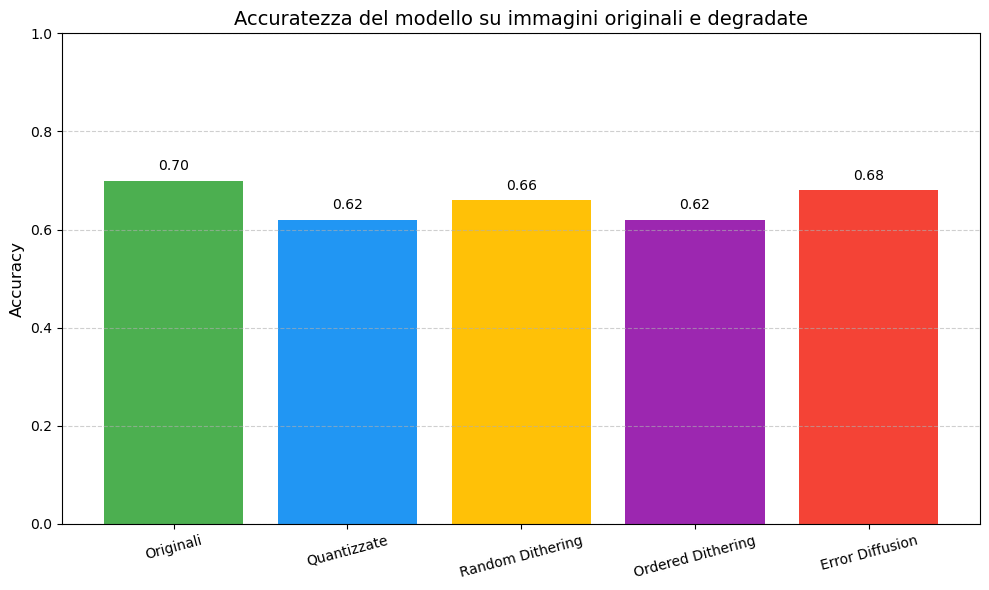

In [12]:
# Estraggo chiavi e valori dal dizionario accuracies per il grafico
labels = list(accuracies.keys())
values = list(accuracies.values())

# Colori diversi per ogni barra
colors = ['#4CAF50', '#2196F3', '#FFC107', '#9C27B0', '#F44336']

# Creazione del grafico
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors)

# Etichette sopra ogni barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.015, f"{height:.2f}", 
             ha='center', va='bottom', fontsize=10)

# Personalizzazione del grafico
plt.title("Accuratezza del modello su immagini originali e degradate", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1.0)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## 7.2 Analisi degli Errori: Confusion Matrix

Per approfondire la valutazione del nostro modello, analizziamo ora le **confusion matrix** ottenute su ciascun test set degradato.

La **confusion matrix** è uno strumento utile per osservare **quali classi vengono maggiormente confuse** dal modello.  
Ogni matrice rappresenta:

- le **righe** come le classi reali
- le **colonne** come le classi predette

Un modello ideale mostra valori alti solo sulla **diagonale principale**, indicando che la classe predetta corrisponde sempre a quella reale.

Nel nostro caso, genereremo e visualizzeremo una confusion matrix normalizzata per ciascuna delle seguenti versioni del test set:
- Immagini originali
- Quantizzate
- Random Dithering
- Ordered Dithering
- Error Diffusion


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


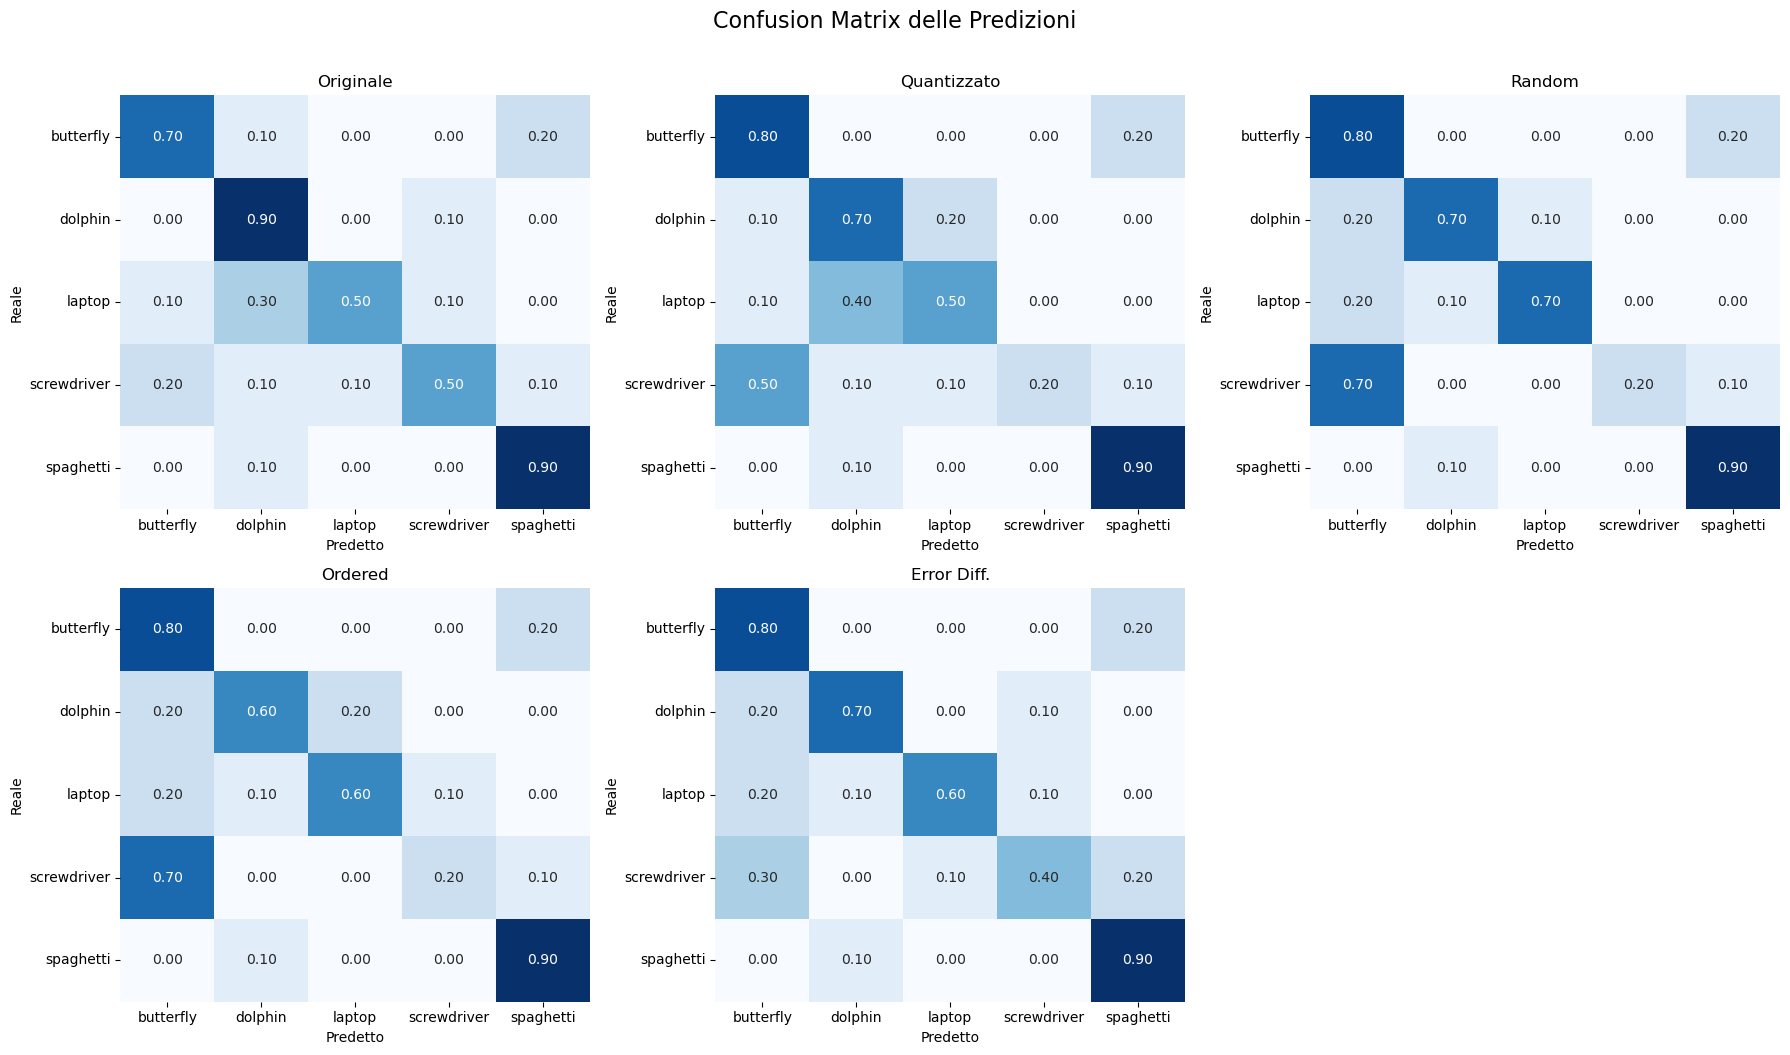

In [13]:
# Mapping delle versioni del test set
test_sets = {
    "Originale":    X_test,
    "Quantizzato":  X_test_quant,
    "Random":       X_test_random,
    "Ordered":      X_test_ordered,
    "Error Diff.":  X_test_error
}

# Impostazioni grafiche
plt.figure(figsize=(18, 10))

for i, (name, X_set) in enumerate(test_sets.items(), 1):
    # Prendo le predizioni del modello sul test set corrente
    y_pred = np.argmax(model.predict(X_set), axis=1)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    # Plot
    plt.subplot(2, 3, i)    
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)

    plt.title(name)
    plt.xlabel("Predetto")
    plt.ylabel("Reale")

plt.tight_layout()
plt.suptitle("Confusion Matrix delle Predizioni", fontsize=16, y=1.05)
plt.show()
